# Budget patch inspection

Take the first five Halevy observation IDs, confirm budget consistency across subjects, generate the feasible patch set for those five budgets (mirroring the MATLAB genX logic), and plot the budget lines.

In [8]:
import os
from pathlib import Path
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import linprog

# Keep MKL/OpenMP single-threaded to avoid SHM issues in constrained envs
os.environ.setdefault("MKL_THREADING_LAYER", "SEQUENTIAL")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("KMP_AFFINITY", "disabled")
os.environ.setdefault("KMP_INIT_AT_FORK", "FALSE")

DATA_PATH = Path("../data/Halevy_Data_adjusted.csv")
df = pd.read_csv(DATA_PATH)
df.head()

,Subject,Observation,X,Y,X-intercept,Y-intercept,X_old,Y_old,income_before,income_after,abs_delta
0,201,1,70.201917,10.405490,100.00,34.92,70.2,10.4,0.999824,1.0,0.005816
1,201,2,10.000000,40.000000,20.00,80.00,10.0,40.0,1.000000,1.0,0.000000
2,201,3,29.997932,29.997823,61.57,58.50,30.0,30.0,1.000071,1.0,0.003002
3,201,4,69.607463,19.810948,98.67,67.26,69.6,19.8,0.999762,1.0,0.013250
4,201,5,40.000000,40.000000,80.00,80.00,40.0,40.0,1.000000,1.0,0.000000


In [9]:
# Select the first five observation IDs
obs_ids = sorted(df["Observation"].unique())[:5]
df5 = df[df["Observation"].isin(obs_ids)].copy()

# Check price/intercept stability across subjects for these observations
consistency = (
    df5.groupby("Observation")[["X-intercept", "Y-intercept"]]
    .agg(["min", "max", "nunique"])
    .rename_axis(None)
)

consistency

X-intercept                 Y-intercept               
          min     max nunique         min    max nunique
1      100.00  100.00       1       34.92  34.92       1
2       20.00   20.00       1       80.00  80.00       1
3       61.57   61.57       1       58.50  58.50       1
4       98.67   98.67       1       67.26  67.26       1
5       80.00   80.00       1       80.00  80.00       1

In [10]:
# Build budgets (prices) using median intercepts per observation
budgets = []
intercepts = []
for obs in obs_ids:
    d = df5[df5["Observation"] == obs]
    px = np.median(1.0 / d["X-intercept"])
    py = np.median(1.0 / d["Y-intercept"])
    budgets.append([px, py])
    intercepts.append([np.median(d["X-intercept"]), np.median(d["Y-intercept"])])
budgets = np.array(budgets)
intercepts = np.array(intercepts)

budgets

array([[0.01      , 0.02863688],
       [0.05      , 0.0125    ],
       [0.01624168, 0.01709402],
       [0.01013479, 0.01486768],
       [0.0125    , 0.0125    ]])

In [11]:
def gen_all_candidates(J: int) -> np.ndarray:
    """Generate (0,-1,1)-strings with exactly one zero, as in RUM_31_genX."""
    combos = []
    for zero_pos in range(J):
        for signs in product([-1, 1], repeat=J - 1):
            row = []
            idx = 0
            for j in range(J):
                if j == zero_pos:
                    row.append(0)
                else:
                    row.append(signs[idx])
                    idx += 1
            combos.append(row)
    return np.array(combos, dtype=int)

TOL_EQ = 1e-9
TOL_STRICT = 1e-6


def patch_feasible(row: np.ndarray, budgets: np.ndarray) -> bool:
    """Match RUM_32_genXdroprow feasibility test using linprog."""
    A = []
    b = []
    for sign, p in zip(row, budgets):
        if sign == 0:
            # |p·x - 1| <= TOL_EQ
            A.append(p)
            b.append(1 + TOL_EQ)
            A.append(-p)
            b.append(-(1 - TOL_EQ))
        elif sign == 1:
            # p·x >= 1 + TOL_STRICT
            A.append(-p)
            b.append(-(1 + TOL_STRICT))
        else:  # sign == -1
            # p·x <= 1 - TOL_STRICT
            A.append(p)
            b.append(1 - TOL_STRICT)
    # x >= 0 constraint
    A.extend(-np.eye(budgets.shape[1]))
    b.extend([0.0] * budgets.shape[1])

    res = linprog(
        c=np.zeros(budgets.shape[1]),
        A_ub=np.array(A, dtype=float),
        b_ub=np.array(b, dtype=float),
        bounds=[(0, None)] * budgets.shape[1],
        method="highs",
    )
    return res.status in (0, 3)  # 0=optimal, 3=unbounded


def feasible_patches(budgets: np.ndarray) -> np.ndarray:
    candidates = gen_all_candidates(budgets.shape[0])
    mask = [patch_feasible(row, budgets) for row in candidates]
    return candidates[np.array(mask)]


patches = feasible_patches(budgets)
patches.shape


(19, 5)

In [14]:
# Peek at the first few feasible patches
patches

array([[ 0, -1, -1, -1, -1],
       [ 0,  1, -1, -1, -1],
       [ 0,  1,  1, -1, -1],
       [ 0,  1,  1, -1,  1],
       [ 0,  1,  1,  1,  1],
       [-1,  0, -1, -1, -1],
       [ 1,  0, -1, -1, -1],
       [ 1,  0,  1, -1, -1],
       [ 1,  0,  1,  1, -1],
       [-1,  1,  0, -1, -1],
       [ 1, -1,  0, -1, -1],
       [ 1,  1,  0, -1, -1],
       [-1,  1,  1,  0,  1],
       [ 1, -1,  1,  0, -1],
       [ 1,  1,  1,  0, -1],
       [ 1,  1,  1,  0,  1],
       [-1,  1,  1, -1,  0],
       [ 1,  1,  1, -1,  0],
       [ 1,  1,  1,  1,  0]])

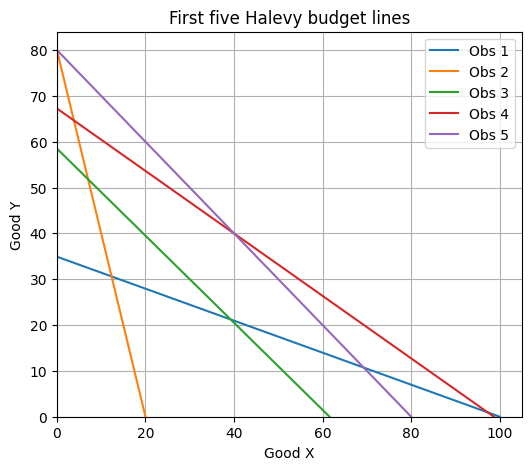

In [13]:
# Plot the five budget lines
plt.figure(figsize=(6, 5))
for (x_int, y_int), obs in zip(intercepts, obs_ids):
    plt.plot([0, x_int], [y_int, 0], label=f"Obs {obs}")
plt.xlabel("Good X")
plt.ylabel("Good Y")
plt.title("First five Halevy budget lines")
plt.legend()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.show()